In [61]:
"""demo
@ https://github.com/Audhil/tensorflow_cookbook/blob/master/07_Natural_Language_Processing/02_Working_with_Bag_of_Words/02_bag_of_words.ipynb"""

import tensorflow as tf
import os
import csv
import requests
import matplotlib.pyplot as plt
from zipfile import ZipFile
import io
import string
from tensorflow.contrib import learn
import numpy as np

os_path = os.path


In [62]:
folder_name = 'SPAM_HAM_DIR'
file_name = 'spam_ham_file.csv'

file_loc = os_path.join(folder_name, file_name)

zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
spam_file_name = 'SMSSpamCollection'

# create folder if un available
if not os_path.exists(folder_name):
    os.mkdir(folder_name)

if os_path.isfile(file_loc):
    """Load from file"""
    text_data = []
    with open(file_loc, 'r') as csv_file:
        reader = csv.reader(csv_file)
        for row in reader:
            text_data.append(row)
else:
    """Download the data"""
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read(spam_file_name)
    # format data
    text_data = file.decode()
    text_data = text_data.encode('ascii', errors='ignore')
    text_data = text_data.decode().split('\n')
    text_data = [x.split('\t') for x in text_data if len(x) >= 1]

    # write to csv
    with open(file_loc, 'w') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerows(text_data)

texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]


In [63]:
"""To reduce the potential vocabulary size, we normalize the text. 
To do this, we remove the influence of capitalization and numbers in the text."""

# Relabel 'spam' as 1, 'ham' as 0
target = [1 if x == 'spam' else 0 for x in target]

# normalize text
# lower case
texts = [x.lower() for x in texts]
# print('texts 1: \n', texts)

# remove punctuations
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]

# remove numbers
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]

# Trim extra whitespace
texts = [' '.join(x.split()) for x in texts]


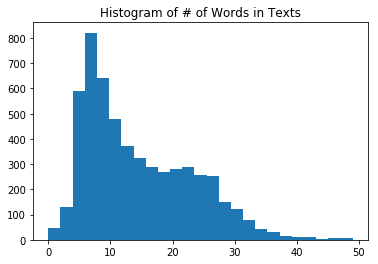

In [64]:
# To determine a good sentence length to pad/crop at, we plot a histogram of text lengths (in words)
% matplotlib inline
# Plot histogram of text lengths
text_lengths = [len(x.split()) for x in texts]
text_lengths = [x for x in text_lengths if x < 50]

plt.hist(text_lengths, bins=25)
plt.title('Histogram of # of Words in Texts')
plt.show()

In [65]:
"""We crop/pad all texts to be 25 words long. We also will filter out any words that do not appear at least 3 times."""
# max word length, and min frequency
sentence_size = 25
min_word_repeat_frequency = 3

# TensorFlow has a built in text processing function called VocabularyProcessor(). 
# We use this function to process the texts.
vocab_processor = learn.preprocessing.VocabularyProcessor(sentence_size, min_frequency=min_word_repeat_frequency)

# Have to fit transform to get length of unique words.
vocab_processor.transform(texts)
embedding_size = len([x for x in vocab_processor.transform(texts)])

# splitting data to train/test
train_indices = np.random.choice(len(texts), round(len(texts) * .8), replace=False)
test_indices = np.array(list(set(range(len(texts))) - set(train_indices)))
texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]

target_train = [x for ix, x in enumerate(target) if ix in train_indices]
target_test = [x for ix, x in enumerate(target) if ix in test_indices]

# For one-hot-encoding, we setup an identity matrix for the TensorFlow embedding lookup.
# We also create the variables and placeholders for the logistic regression we will perform.

# Setup Index Matrix for one-hot-encoding
identity_mat = tf.diag(tf.ones(shape=[embedding_size]))

# Create variables for logistic regression
A = tf.Variable(tf.random_normal(shape=[embedding_size, 1]))
b = tf.Variable(tf.random_normal(shape=[1, 1]))

# placeholders
x_data = tf.placeholder(tf.float32, shape=[sentence_size])
y_target = tf.placeholder(tf.float32, shape=[1, 1])



# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     print(sess.run(identity_mat))


Tensor("Diag_2:0", shape=(10, 10), dtype=float32)
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
